# Task 2 Review Sentiment Classification

1 mission:Load the data from Task 1 and create a set of documents, one per review. Each document should consist of the concatenation of the review’s title and body text. 

In [114]:
# Importing all required libraries 
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pprint
import sys
import re

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS

# i. Data Preperation & Visualisation

First we need to read the CSV data from Task1.

In [115]:
allreviews_df = pd.read_csv('allreviewsdata.csv')

In [116]:
allreviews_df

,Stars,Titles,Main,HelpfulVotes,TotalVotes
0,1,Must have been a contaminated batch,We bought a case of 12 12 oz cans back in Apri...,20,22
1,5,Even more useful than regular parchment paper,I originally bought this just because it was c...,19,19
2,5,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",472,477
3,5,"great product, worth every penny",I've struggled with sleep and muscle tension f...,10,12
4,1,Curiously awful,Cola is by far my favorite drink. My wife and ...,1,14
...,...,...,...,...,...
9239,5,Cat Scratch Fever!!,"I opened up the cat scratcher, spread a little...",27,27
9240,5,"Great Noodles, but not spaghetti",I lived in Japan for many years & really enjoy...,23,23
9241,4,mmmmm chips :),"Well there isn't much to say about these, you ...",17,18
9242,5,Nothing Better,I've been eating Claxton Fruitcake since I was...,12,14


As you can see from here, a total of 9244 star ratings were made in our data, which is the same number as the number of votes, representing a total of 9244 comments.

In [117]:
allreviews_df.describe()

,Stars,HelpfulVotes,TotalVotes
count,9244.000000,9244.000000,9244.000000
mean,3.410537,21.258762,26.419083
std,1.751431,32.163088,32.897479
min,1.000000,0.000000,12.000000
25%,1.000000,10.000000,14.000000
50%,4.000000,14.000000,18.000000
75%,5.000000,22.000000,26.000000
max,5.000000,580.000000,593.000000


We can remove null values next

In [118]:
allreviews_df=allreviews_df.dropna()
allreviews_df = allreviews_df.reset_index(drop=True)

Assign a class label (“positive” or “negative”) to each review. We will assume that 1-star to 3-star reviews are “negative”, and 4-star to 5-star reviews are “positive”.Assign a class label (“helpful” or “unhelpful”) to each review in your dataset from Task 2, based on its associated helpfulness information.


In [119]:
allreviews_df['Label']=np.where(allreviews_df["Stars"]>=4,'P','N') #P means Positve,N means Negative
allreviews_df["UsefulScore"] = (allreviews_df["HelpfulVotes"]/allreviews_df["TotalVotes"]).apply(lambda n: "helpful" if n > 0.8 else "unhelpful")
allreviews_df

,Stars,Titles,Main,HelpfulVotes,TotalVotes,Label,UsefulScore
0,1,Must have been a contaminated batch,We bought a case of 12 12 oz cans back in Apri...,20,22,N,helpful
1,5,Even more useful than regular parchment paper,I originally bought this just because it was c...,19,19,P,helpful
2,5,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",472,477,P,helpful
3,5,"great product, worth every penny",I've struggled with sleep and muscle tension f...,10,12,P,helpful
4,1,Curiously awful,Cola is by far my favorite drink. My wife and ...,1,14,N,unhelpful
...,...,...,...,...,...,...,...
9239,5,Cat Scratch Fever!!,"I opened up the cat scratcher, spread a little...",27,27,P,helpful
9240,5,"Great Noodles, but not spaghetti",I lived in Japan for many years & really enjoy...,23,23,P,helpful
9241,4,mmmmm chips :),"Well there isn't much to say about these, you ...",17,18,P,helpful
9242,5,Nothing Better,I've been eating Claxton Fruitcake since I was...,12,14,P,helpful


Visualisation like :

In [120]:
allreviews_df['Stars'].value_counts()

5    4500
1    2627
4     726
3     714
2     677
Name: Stars, dtype: int64

<AxesSubplot:ylabel='Frequency'>

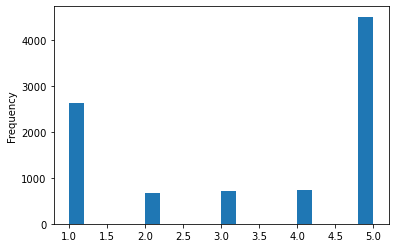

In [121]:
allreviews_df['Stars'].plot.hist(bins=20)

In [122]:
allreviews_df['Label'].value_counts()

P    5226
N    4018
Name: Label, dtype: int64

In [123]:
allreviews_df['UsefulScore'].value_counts()

helpful      6008
unhelpful    3236
Name: UsefulScore, dtype: int64

Concanication Titles + Main

In [124]:
allreviews_df ['Full_Reviews'] = allreviews_df['Titles'] + ' ' + allreviews_df['Main']

In [125]:
# Checking if it concanicated properly
with pd.option_context('display.max_colwidth', None):
     display(allreviews_df ['Full_Reviews'][0])

"Must have been a contaminated batch We bought a case of 12 12 oz cans back in April. Just now opened the first can. Wow. Consistency of vomit, grayish tinge, and a vile odor. Opened a second can -- exactly the same. No way were we going to feed it to our dog. Something was clearly wrong. We've been buying Newman's Own dog food for the last two years (since we got a dog) and never experienced anything like this. Interesting to look back at the reviews here and see three from the April - May timeframe that sound like there may have been similar issues for others around the same time we made our purchase. Guessing there must have been a production run that resulted in contaminated product. We've reported the issue to both Newman's Own and the FDA. …"

In [126]:
# Dropping unnecessary columns & adding news id
concat_data = allreviews_df.drop(['Titles', 'Main'], axis=1)
concat_data.head(10)

,Stars,HelpfulVotes,TotalVotes,Label,UsefulScore,Full_Reviews
0,1,20,22,N,helpful,Must have been a contaminated batch We bought ...
1,5,19,19,P,helpful,Even more useful than regular parchment paper ...
2,5,472,477,P,helpful,"This filter works PERFECT! Seriously, I love m..."
3,5,10,12,P,helpful,"great product, worth every penny I've struggle..."
4,1,1,14,N,unhelpful,Curiously awful Cola is by far my favorite dri...
5,5,0,14,P,unhelpful,i love insanely spicy things i haven't actuall...
6,5,15,19,P,unhelpful,Its supposed to burn your throat! I read many ...
7,4,11,14,P,unhelpful,"No evil 'sucralose', thank goodness! Many ener..."
8,1,7,13,N,unhelpful,"over price This item is really over price, i c..."
9,5,71,72,P,helpful,miracle honey This honey was suggested for my ...


To see the most words in highest stars review and the lowest stars reviews 

In [127]:
concat_data[concat_data.Stars == 5].head()

,Stars,HelpfulVotes,TotalVotes,Label,UsefulScore,Full_Reviews
1,5,19,19,P,helpful,Even more useful than regular parchment paper ...
2,5,472,477,P,helpful,"This filter works PERFECT! Seriously, I love m..."
3,5,10,12,P,helpful,"great product, worth every penny I've struggle..."
5,5,0,14,P,unhelpful,i love insanely spicy things i haven't actuall...
6,5,15,19,P,unhelpful,Its supposed to burn your throat! I read many ...


In [128]:
concat_data[concat_data.Stars == 1].head()

,Stars,HelpfulVotes,TotalVotes,Label,UsefulScore,Full_Reviews
0,1,20,22,N,helpful,Must have been a contaminated batch We bought ...
4,1,1,14,N,unhelpful,Curiously awful Cola is by far my favorite dri...
8,1,7,13,N,unhelpful,"over price This item is really over price, i c..."
11,1,16,16,N,helpful,Error 404: Caramel flavor not found There is n...
12,1,12,13,N,helpful,Looks like 70% of Cherry Tomato Reviews are NE...


# Data Cleaning:

In [129]:
    # Checking if the data contains the Null Values
concat_data.isna().values.any()

False

In [130]:
# Checking if we have empty full reviews strings
(concat_data['Full_Reviews'].str.len() == 0).any()

False

# Feature extraction from reviewsText

Assign new dimension to each word and give the word counts

In [131]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

concat_data["Full_ReviewsClean"] = concat_data["Full_Reviews"].apply(cleanReviews)

train, test = train_test_split(concat_data, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

7395 items in training data, 1849 in test data


Using TfidfTransformer().fit_transofrm to fit the train and test data

In [132]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["Full_ReviewsClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["Full_ReviewsClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Label"]
y_test = test["Label"]

prediction = dict()

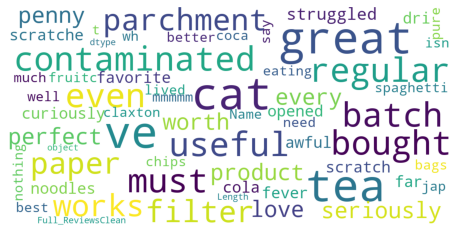

In [133]:
stopwords = set(STOPWORDS)

mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(concat_data["Full_ReviewsClean"])

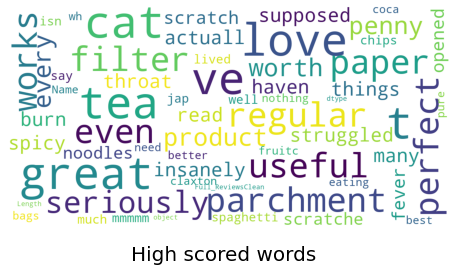

In [134]:
show_wordcloud(concat_data[concat_data.Stars >= 4]["Full_ReviewsClean"], title = "High scored words")

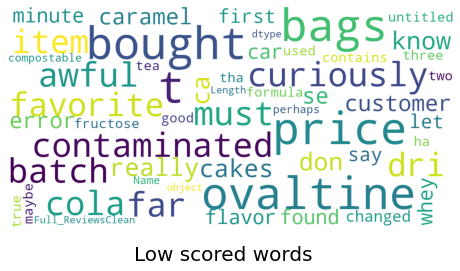

In [135]:
show_wordcloud(concat_data[concat_data.Stars <= 3]["Full_ReviewsClean"], title = "Low scored words")

# Multinomial Naïve Bayes learning method

In [136]:
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

# Logistic regression learning method

In [ ]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

# Result

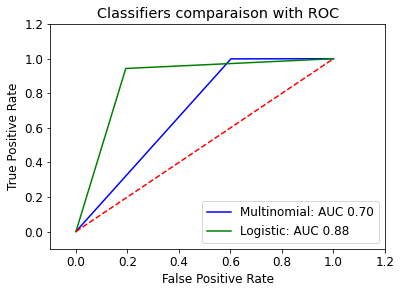

In [138]:
def formatt(x):
    if x == 'N':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Visualize the accuracy, recall and f1-score for Logistic Regression

In [139]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.91      0.81      0.86       786
    negative       0.87      0.94      0.90      1063

    accuracy                           0.89      1849
   macro avg       0.89      0.88      0.88      1849
weighted avg       0.89      0.89      0.88      1849



In [140]:
accuracy_score(y_test, prediction['Logistic'])

0.8853434288804759

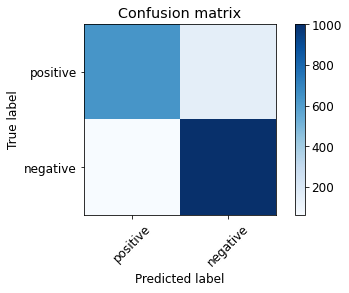

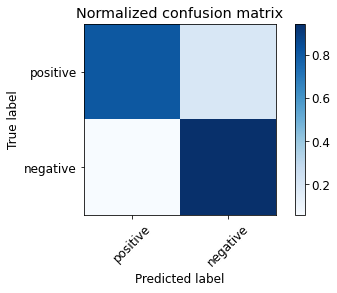

In [141]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

# Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial

In [142]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       1.00      0.40      0.57       786
    negative       0.69      1.00      0.82      1063

    accuracy                           0.74      1849
   macro avg       0.84      0.70      0.69      1849
weighted avg       0.82      0.74      0.71      1849



In [143]:
accuracy_score(y_test, prediction['Multinomial'])

0.7436452136289886

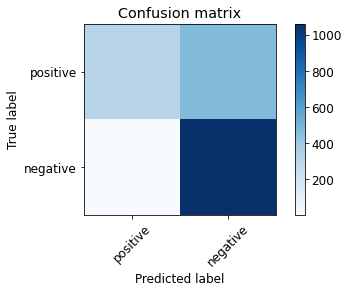

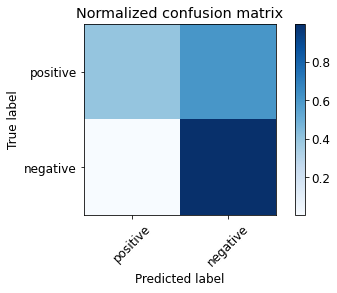

In [144]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

We got a classifier accuracy of 89% in Logistic Regression and 74% in Naive Bayes Multinomial. It can be clearly concluded that the Logistic Regression method is more suitable for sentiment classification in Task2 compared to the two classifiers.Displaying words depicting the best and worst features

In [145]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
900113,not,-54.698130
366020,disappointed,-24.059990
141767,bad,-23.804832
844705,money,-22.271127
1550577,was,-19.593896
...,...,...
427189,excellent,29.927901
349572,delicious,34.346019
50357,and,39.494053
176726,best,41.536886


Testing the sentiments of few reviews

In [146]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "excellent and best thing")
testSentiments(logreg, "Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.")
testSentiments(logreg, "Nasty smelling shampoo!.")

Sample estimated as P: negative prob 0.000000, positive prob 1.000000
Sample estimated as N: negative prob 0.995988, positive prob 0.004012
Sample estimated as N: negative prob 0.991158, positive prob 0.008842


# Task 3 Review Helpfulness Classification

In [147]:
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["Full_ReviewsClean"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["Full_ReviewsClean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["UsefulScore"]
y_test = test["UsefulScore"]

prediction = dict()

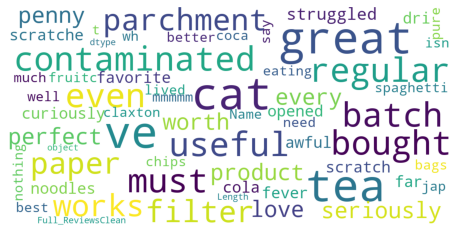

In [148]:
stopwords = set(STOPWORDS)

mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(concat_data["Full_ReviewsClean"])

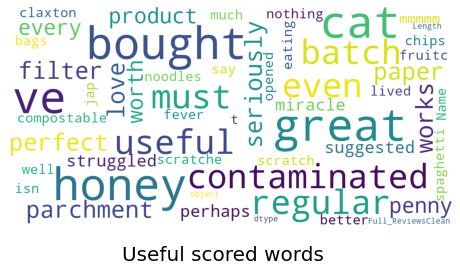

In [149]:
show_wordcloud(concat_data[(concat_data.HelpfulVotes)/(concat_data.TotalVotes) > 0.8]["Full_ReviewsClean"], title = "Useful scored words")

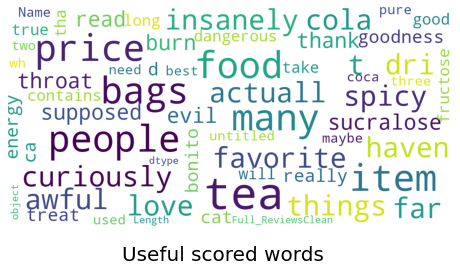

In [150]:
show_wordcloud(concat_data[(concat_data.HelpfulVotes)/(concat_data.TotalVotes) <= 0.8]["Full_ReviewsClean"], title = "Useful scored words")

# Multinomial Naïve Bayes learning method

In [151]:
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

# Logistic regression learning method

In [ ]:
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

# Result

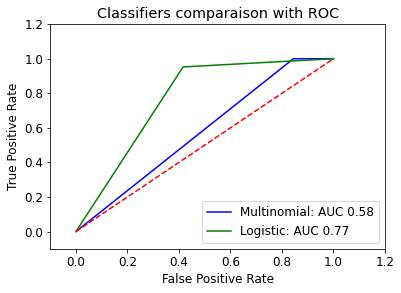

In [153]:
def formatt(x):
    if x == 'unhelpful':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Visualize the accuracy, recall and f1-score for Logistic Regression

In [105]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["helpful", "useless"]))

              precision    recall  f1-score   support

     usefull       0.80      0.95      0.87      1198
     useless       0.86      0.57      0.69       651

    accuracy                           0.82      1849
   macro avg       0.83      0.76      0.78      1849
weighted avg       0.82      0.82      0.81      1849



In [106]:
accuracy_score(y_test, prediction['Logistic'])

0.8171984856679286

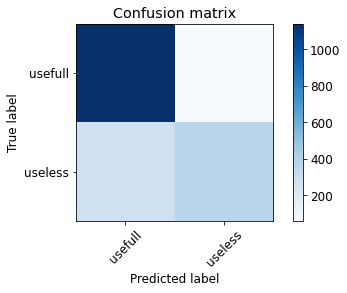

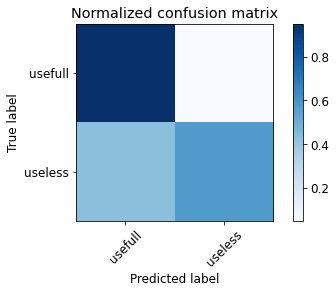

In [107]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["usefull", "useless"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

# Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial

In [108]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["usefull", "useless"]))

              precision    recall  f1-score   support

     usefull       0.69      1.00      0.82      1198
     useless       0.98      0.18      0.30       651

    accuracy                           0.71      1849
   macro avg       0.84      0.59      0.56      1849
weighted avg       0.79      0.71      0.64      1849



In [109]:
accuracy_score(y_test, prediction['Multinomial'])

0.709572742022715

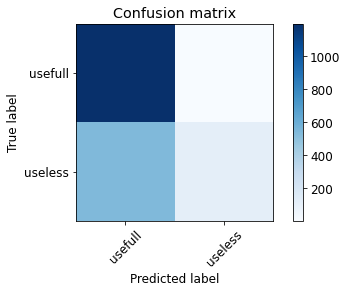

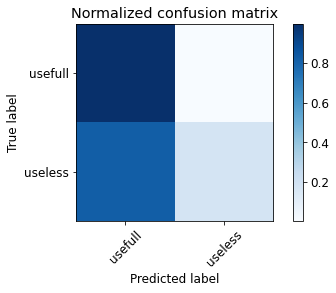

In [110]:
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.Blues, labels=["usefull", "useless"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
matrix = confusion_matrix(y_test, prediction['Multinomial'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(matrix)    

matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(matrix_normalized, title='Normalized confusion matrix')
plt.show()

We got a classifier accuracy of 81.7% in Logistic Regression and 70% in Naive Bayes Multinomial. It can be clearly concluded that the Logistic Regression method is more suitable for sentiment classification in Task2 compared to the two classifiers.Displaying words depicting the best and worst features

In [111]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(features, logreg_result.coef_[0])),
    columns = ['feature', 'coefficient'])

feature_coefs.sort_values(by='coefficient')

,feature,coefficient
556509,great,-45.734267
50680,and,-37.183679
1184836,she,-30.659939
351829,delicious,-27.527324
430256,excellent,-25.528710
...,...,...
199098,bottle,17.735778
620648,horrible,19.621625
1639158,worst,20.808088
391397,drink,22.118032


In [113]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

testSentiments(logreg, "very good and delicious food")
testSentiments(logreg, "not a good place for any human.")
testSentiments(logreg, "Nasty smelling shampoo!.")

Sample estimated as USEFUL: negative prob 1.000000, positive prob 0.000000
Sample estimated as USELESS: negative prob 0.017207, positive prob 0.982793
Sample estimated as USELESS: negative prob 0.000190, positive prob 0.999810


# Conclution

By comparing the use of the two classifiers in different contexts, it can be found that the text classifier for the emotional use context is more accurate than the text classifier for the helper context. The reason for this may be that in expressing emotions, the words people use are more representative. Whether it is helpful often cannot be judged directly from the words expressed in the comments. It is worth noting that with the help of Python, it can be found that negative comments are often more likely to be perceived as helpful.